In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import os,sys,glob
from math import *
import xarray as xr
import pickle
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy import optimize
from scipy.io import loadmat
from scipy.stats import linregress

In [2]:
# Load own modules
projectname = 'EUREC4A_organization'
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
repodir = rootdir
moduledir = os.path.join(repodir,'functions')
resultdir = os.path.join(repodir,'results','idealized_calculations')
figdir = os.path.join(repodir,'figures','idealized_calculations')
inputdir = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
resultinputdir = os.path.join(repodir,'results','radiative_features')
radinputdir = os.path.join(repodir,'input')
scriptsubdir = 'observed_moist_intrusions'

os.makedirs(os.path.join(figdir,scriptsubdir),exist_ok=True)
os.makedirs(os.path.join(resultdir,scriptsubdir),exist_ok=True)

In [3]:
# current environment
thismodule = sys.modules[__name__]

##-- Own modules
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

#- Parameters & constants
from thermoConstants import *
from thermoFunctions import *
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

mo = MatrixOperators()

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats', 'thermoFunctions', 'thermoConstants', 'radiativescaling', 'radiativefeatures', 'matrixoperators']


In [4]:
days =          '20200122','20200124','20200126','20200128','20200131','20200202','20200205','20200207','20200209','20200211','20200213'
name_pattern =  'Fish',    'Fish',    'Fish',    'Gravel',  'Fish',    'Flower',  'Gravel',  'Flower',    'Sugar',   'Sugar',   'Fish'
confidence_pattern = 'High','Medium', 'Medium',     'Low',     'Low',     'High',    'High',    'High',  'Medium',  'Medium',  'High'
col_pattern = {'':'silver',
               'Fish':'navy',
               'Gravel':'orange',
               'Sugar':'seagreen',
               'Flower':'firebrick'}

dim_t,dim_z = 0,1
    
# box GOES images
lat_box_goes = 10,16
lon_box_goes = -60,-52

# box of analysis
lat_box = 11,16
lon_box = -60,-52

# varids
ref_varid = 'PW'
cond_varids = 'QRAD','QRADSW','QRADLW','QV','UNORM','T','P'



#--- load data

# Profiles
radprf = xr.open_dataset(os.path.join(inputdir,'rad_profiles_CF.nc'))
# choose profiles for that day that start at bottom
data_all = radprf.where(radprf.z_min<=50,drop=True)

z = data_all.alt.values/1e3 # km
pres = np.nanmean(data_all.pressure.data,axis=dim_t)/100 # hPa


rad_features_all = {}
rad_scaling_all = {}
ref_dist_all = {}
cond_dist_all = {}

# initalize
for cond_varid in cond_varids:
     cond_dist_all[cond_varid] = {}

for day in days:

    #-- Radiative features
    features_filename = 'rad_features.pickle'
    print('loading %s'%features_filename)
    # load
    features_path = os.path.join(resultinputdir,day,features_filename)
    f = pickle.load(open(features_path,'rb'))
    # store
    rad_features_all[day] = f

    #-- Radiative scaling
    rad_scaling_filename = 'rad_scaling.pickle'
    print('loading %s'%rad_scaling_filename)
    rad_scaling_path = os.path.join(resultinputdir,day,rad_scaling_filename)
    rs = pickle.load(open(rad_scaling_path,'rb'))
    # store
    rad_scaling_all[day] = rs

    #-- Reference PW distribution
    ref_filename = 'dist_%s.pickle'%(ref_varid)
    print('load reference %s distribution'%ref_varid)
    ref_dist_path = os.path.join(resultinputdir,day,ref_filename)
    ref_dist = pickle.load(open(ref_dist_path,'rb'))
    # save in current environment
    ref_dist_all[day] = ref_dist

    #-- Conditional distributions
    for cond_varid in cond_varids:

        # load
        cond_filename = 'cdist_%s_on_%s.pickle'%(cond_varid,ref_varid)
        print('loading %s'%cond_filename)
        cond_dist_path = os.path.join(resultinputdir,day,cond_filename)
        cond_dist = pickle.load(open(cond_dist_path,'rb'))
        # save in current environment
        cond_dist_all[cond_varid][day] = cond_dist


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


loading rad_features.pickle
loading rad_scaling.pickle
load reference PW distribution
loading cdist_QRAD_on_PW.pickle
loading cdist_QRADSW_on_PW.pickle
loading cdist_QRADLW_on_PW.pickle
loading cdist_QV_on_PW.pickle
loading cdist_UNORM_on_PW.pickle
loading cdist_T_on_PW.pickle
loading cdist_P_on_PW.pickle
loading rad_features.pickle
loading rad_scaling.pickle
load reference PW distribution
loading cdist_QRAD_on_PW.pickle
loading cdist_QRADSW_on_PW.pickle
loading cdist_QRADLW_on_PW.pickle
loading cdist_QV_on_PW.pickle
loading cdist_UNORM_on_PW.pickle
loading cdist_T_on_PW.pickle
loading cdist_P_on_PW.pickle
loading rad_features.pickle
loading rad_scaling.pickle
load reference PW distribution
loading cdist_QRAD_on_PW.pickle
loading cdist_QRADSW_on_PW.pickle
loading cdist_QRADLW_on_PW.pickle
loading cdist_QV_on_PW.pickle
loading cdist_UNORM_on_PW.pickle
loading cdist_T_on_PW.pickle
loading cdist_P_on_PW.pickle
loading rad_features.pickle
loading rad_scaling.pickle
load reference PW distri

In [5]:
days_high_peaks = '20200213', '20200213', '20200211', '20200209', '20200209', '20200128'
z_min_all = 5000, 4000, 4000, 3500, 5500, 4000
z_max_all = 9000, 5000, 6000, 5500, 8500, 6000
z_breaks_0_all = [1.8,2,4,5,6.5,7], [1.8,2,4,5], [2,3.5,4.5,5], [2,2.5,4.5,5], [2,2.5,5,7], [2,2.5,4.5,5] 
rh_breaks_0_all = [0.8,0.1,0.7,0.1,0.7,0.1], [0.8,0.1,0.7,0.1], [0.8,0.3,0.7,0.05], [0.75,0.1,0.25,0.05], [0.75,0.1,0.25,0.05], [0.75,0.1,0.25,0.05] 
colors = 'blue','orange','green','red','purple','brown'

def getProfiles(rad_features, data_day, z_min, z_max):
    
    #- Mask
    # |qrad| > 5 K/day
    qrad_peak = np.absolute(rad_features.qrad_lw_peak)
    keep_large = qrad_peak > 5 # K/day
    # in box
    lon_day = data_day.longitude[:,50]
    lat_day = data_day.latitude[:,50]
    keep_box = np.logical_and(lon_day < lon_box[1], lat_day >= lat_box[0])
    # high-level peak
    keep_high =  np.logical_and(rad_features.z_net_peak < z_max, # m
                                rad_features.z_net_peak > z_min)
    # combined
    k = np.logical_and(np.logical_and(keep_large,keep_box),keep_high)
    
    # temperature
    temp = data_day.temperature.values[k,:]
    # relative humidity
    rh = data_day.relative_humidity.values[k,:]
    # specific humidity 
    qv = data_day.specific_humidity.values[k,:]
    # lw cooling
    qradlw = rad_features.qrad_lw_smooth[k,:]
    
    return temp, qv, rh, qradlw

-- day 20200213


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.7 z + 298.4, r = -0.99
ln(qvstar) = 2.5 ln(p) + -20.8, r = 0.99
alpha = 2.46, qvstar(1000hPa) = -3.85
intrusion top height: 447.149126hPa, 6.77km
intrusion center height: 499.322507hPa, 5.91km
intrusion bottom height: 570.551319hPa, 4.85km
intrusion mass: 1.39mm
-- day 20200213


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.8 z + 298.2, r = -0.99
ln(qvstar) = 2.6 ln(p) + -21.7, r = 0.99
alpha = 2.58, qvstar(1000hPa) = -3.84
intrusion top height: 558.582872hPa, 5.02km
intrusion center height: 679.204193hPa, 3.43km
intrusion bottom height: 799.141003hPa, 2.06km
intrusion mass: 5.87mm
-- day 20200211


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.8 z + 298.5, r = -1.00
ln(qvstar) = 2.6 ln(p) + -21.7, r = 0.99
alpha = 2.59, qvstar(1000hPa) = -3.80
intrusion top height: 559.279589hPa, 5.01km
intrusion center height: 613.049101hPa, 4.27km
intrusion bottom height: 679.204193hPa, 3.43km
intrusion mass: 2.10mm
-- day 20200209


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.9 z + 298.7, r = -1.00
ln(qvstar) = 2.7 ln(p) + -22.6, r = 0.99
alpha = 2.72, qvstar(1000hPa) = -3.78
intrusion top height: 555.797407hPa, 5.06km
intrusion center height: 639.951308hPa, 3.92km
intrusion bottom height: 754.893140hPa, 2.54km
intrusion mass: 1.55mm
-- day 20200209


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.8 z + 297.8, r = -1.00
ln(qvstar) = 2.6 ln(p) + -21.7, r = 0.99
alpha = 2.58, qvstar(1000hPa) = -3.88
intrusion top height: 450.057435hPa, 6.72km
intrusion center height: 607.787726hPa, 4.34km
intrusion bottom height: 743.337790hPa, 2.67km
intrusion mass: 1.42mm
-- day 20200128


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


T(z) = -5.8 z + 300.8, r = -0.99
ln(qvstar) = 2.6 ln(p) + -21.3, r = 0.97
alpha = 2.56, qvstar(1000hPa) = -3.65
intrusion top height: 519.921487hPa, 5.59km
intrusion center height: 630.610011hPa, 4.04km
intrusion bottom height: 744.219872hPa, 2.66km
intrusion mass: 1.99mm


Text(0, 0.5, 'z (km)')

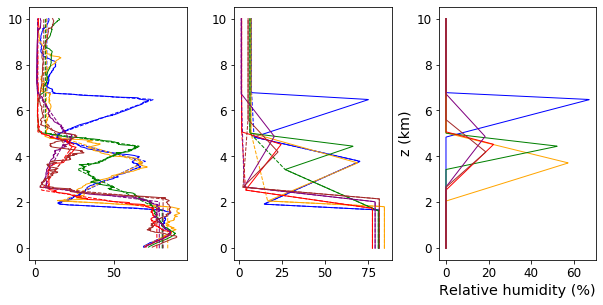

In [6]:
def piecewise_linear(z:np.array,z_breaks:list,rh_breaks:list):
    """
    Define piecewise linear RH shape with constant value at top and bottom.

    Args:
        z (np.array): z coordinate
        z_breaks (list): z values of break points
        rh_breaks (list): rh values of break points

    Returns:
        np.array: piecewize rh
        
    """
    
    N_breaks = len(z_breaks)
    
    cond_list = [z <= z_breaks[0]]+\
                [np.logical_and(z > z_breaks[i-1],z <= z_breaks[i]) for i in range(1,N_breaks)]+\
                [z > z_breaks[N_breaks-1]]
    def make_piece(k):
        def f(z):
            return rh_breaks[k-1]+(rh_breaks[k]-rh_breaks[k-1])/(z_breaks[k]-z_breaks[k-1])*(z-z_breaks[k-1])
        return f 
    func_list = [lambda z: rh_breaks[0]]+\
                [make_piece(k) for k in range(1,N_breaks)]+\
                [lambda z: rh_breaks[N_breaks-1]]
                
    return np.piecewise(z,cond_list,func_list)

def piecewise_fit(z:np.array,rh:np.array,z_breaks_0:list,rh_breaks_0:list):    
    """
    Compute piecewise-linear fit of RH(z).

    Args:
        z (np.array): z coordinate
        rh (np.array): rh profile
        z_breaks_0 (list): initial z values of break points
        rh_breaks_0 (list): initial rh values of break points

    Returns:
        z_breaks (list): fitted z values of break points
        rh_breaks (list): fitted rh values of break points
        rh_id (np.array): piecewize rh fit

    """

    N_breaks = len(z_breaks_0)

    def piecewise_fun(z,*p):
        return piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])

    mask = ~np.isnan(z) & ~np.isnan(rh)

    p , e = optimize.curve_fit(piecewise_fun, z[mask], rh[mask],p0=z_breaks_0+rh_breaks_0)

    rh_id = piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])
    rh_breaks = list(p[N_breaks:2*N_breaks])
    z_breaks = list(p[0:N_breaks])
    
    return z_breaks,rh_breaks,rh_id


def computeWPaboveZ(qv,pres,p_top):
    """Calculates the integrated water path above each level.

    Arguments:
        - qv: specific humidity in kg/kg, Nz-vector
        - pres: pressure coordinate in hPa, Nz vector
        - p_top: pressure of upper integration level

    returns:
        - wp_z: water path above each level, Nz-vector"""

    Np = qv.shape[0]
    wp_z = np.full(Np,np.nan)

    p_increasing = np.diff(pres)[0] > 0
    
    if p_increasing:
        
        i_p_top = np.where(pres >= p_top)[0][0]
        
        for i_p in range(i_p_top,Np):
        # self.wp_z[:,i_z] = self.mo.pressureIntegral(arr=data.specific_humidity[:,i_z:],pres=pres[i_z:],p_levmin=pres[i_z],p_levmax=pres[-1],z_axis=z_axis)

            arr = qv
            p = pres
            p0 = p_top
            p1 = p[i_p]
            i_w = i_p
            
            wp_z[i_w] = mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)

    else:
        
        i_p_top = np.where(pres >= p_top)[0][-1]

        for i_p in range(i_p_top):
            
            arr = np.flip(qv)
            p = np.flip(pres)
            p0 = p_top
            p1 = pres[i_p]
            i_w = i_p

            wp_z[i_w] = mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)

    return wp_z


fig,axs = plt.subplots(ncols=3,figsize=(10.5,4.5))


moist_intrusions = {}

for day, z_min, z_max, z_breaks_0, rh_breaks_0,col \
in zip(days_high_peaks,z_min_all,z_max_all,z_breaks_0_all,rh_breaks_0_all,colors):
    
    print('-- day',day)
    daylab = day
    if day == '20200213':
        if z_max > 6000:
            daylab = '20200213, upper'
        else:
            daylab = '20200213, lower'
    moist_intrusions[daylab] = {'profiles':{},
                             'fit':{},
                             'stats':{}}
    
    date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
    data_day = data_all.sel(launch_time=day)
    rad_features = rad_features_all[day]
    
    heights_label = r'%s; %1.1f $< z_p <$%1.1f km'%(day, z_min/1e3,z_max/1e3)
    temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
    qvstar = qv/rh
    
    # compute interquartile range and median of all profiles types
    temp_Q1, temp_med, temp_Q3 = np.nanpercentile(temp,25,axis=0), np.nanpercentile(temp,50,axis=0), np.nanpercentile(temp,75,axis=0)
    rh_Q1, rh_med, rh_Q3 = np.nanpercentile(rh,25,axis=0), np.nanpercentile(rh,50,axis=0), np.nanpercentile(rh,75,axis=0)
    qradlw_Q1, qradlw_med, qradlw_Q3 = np.nanpercentile(qradlw,25,axis=0), np.nanpercentile(qradlw,50,axis=0), np.nanpercentile(qradlw,75,axis=0)
    qvstar_Q1, qvstar_med, qvstar_Q3 = np.nanpercentile(qvstar,25,axis=0), np.nanpercentile(qvstar,50,axis=0), np.nanpercentile(qvstar,75,axis=0)
    
    # save
    for varid in ['temp','qvstar','rh','qradlw']:

        moist_intrusions[daylab]['profiles'][varid] = {}
        
        for quartile in ['Q1','med','Q3']:
            
            moist_intrusions[daylab]['profiles'][varid][quartile] = getattr(thismodule,'%s_%s'%(varid,quartile))
        
    moist_intrusions[daylab]['profiles']['z'] = z
    moist_intrusions[daylab]['profiles']['pres'] = pres
        
        
    #-- Fits
    # piecewise-linear fit
    z_breaks_id,rh_breaks_id,rh_id = piecewise_fit(z,rh_med,z_breaks_0,rh_breaks_0)

    # remove (upper) intrusion
    rh_breaks_remint = rh_breaks_id.copy()
    rh_breaks_remint[-2] = rh_breaks_id[-3]
    z_breaks_remint = z_breaks_id.copy()
    z_breaks_remint[-2] = z_breaks_id[-3]
    rh_remint = piecewise_linear(z,z_breaks_remint,rh_breaks_remint)

    # Linear fit T(z)
    mask = ~np.isnan(z) & ~np.isnan(temp_med)
    slope, intercept, r, p, se = linregress(z[mask],temp_med[mask])
    print('T(z) = %2.1f z + %3.1f, r = %1.2f'%(slope,intercept,r))
    temp_remint = temp_id = slope*z + intercept

    # power fit qvstar(p)
    mask = ~np.isnan(pres) & ~np.isnan(qvstar_med)
    slope, intercept, r, p, se = linregress(np.log(pres[mask]),np.log(qvstar_med[mask]))
    print('ln(qvstar) = %2.1f ln(p) + %3.1f, r = %1.2f'%(slope,intercept,r))
    print('alpha = %1.2f, qvstar(1000hPa) = %1.2f'%(slope,slope*np.log(1000)+intercept))
    qvstar_remint = qvstar_id = np.exp(slope*np.log(pres) + intercept)

    # save
    for varid in ['z_breaks','rh_breaks','rh','temp','qvstar']:
        for suffix in ['id','remint']:
            varname = '%s_%s'%(varid,suffix)
            moist_intrusions[daylab]['fit'][varname] = getattr(thismodule,varname)

    #-- intrusion statistics
    # intrusion anomaly
    rh_delta_int = rh_id - rh_remint
    
    # intrusion water path
    qvstar = saturationSpecificHumidity(temp_med,pres*100)
    qv_int = rh_delta_int*qvstar
    not_nan = ~np.isnan(qv_int)
    p_top = 300 # hPa
    W_cumul = computeWPaboveZ(qv_int[not_nan],pres[not_nan],p_top)
    W_int = W_cumul[0]
    # center of mass (level)
    where_W_below_half = W_cumul < W_int/2
    p_int_center = pres[not_nan][where_W_below_half][0]
    z_int_center = z[not_nan][where_W_below_half][0]
    # bottom of intrusion
    i_int_bottom = np.where(rh_delta_int>0)[0][0]
    p_int_bottom = pres[i_int_bottom]
    z_int_bottom = z[i_int_bottom]
    # top of intrusion
    i_int_top = np.where(rh_delta_int>0)[0][-1]
    p_int_top = pres[i_int_top]
    z_int_top = z[i_int_top]
    
    # save
    for varid in ['W_int','p_int_center','z_int_center','i_int_top','p_int_top','z_int_top','i_int_bottom','p_int_bottom','z_int_bottom']:
        moist_intrusions[daylab]['stats'][varid] = getattr(thismodule,varid)
    
    print('intrusion top height: %3fhPa, %1.2fkm'%(p_int_top,z_int_top))
    print('intrusion center height: %3fhPa, %1.2fkm'%(p_int_center,z_int_center))
    print('intrusion bottom height: %3fhPa, %1.2fkm'%(p_int_bottom,z_int_bottom))
    print('intrusion mass: %2.2fmm'%W_int)
    
    
    # show
    ax = axs[0]
    ax.plot(rh_med*100,z,linewidth=1,alpha=1,label=heights_label,c=col)
    ax.plot(rh_id*100,z,linewidth=1,alpha=1,label=heights_label,linestyle='--',c=col)
    
    ax = axs[1]
    ax.plot(rh_id*100,z,linewidth=1,alpha=1,label=heights_label,linestyle='-',c=col)
    ax.plot(rh_remint*100,z,linewidth=1,alpha=1,label=heights_label,linestyle='--',c=col)
    
    ax = axs[2]
    ax.plot(rh_delta_int*100,z,linewidth=1,alpha=1,label=heights_label,linestyle='-',c=col)
    
ax.set_xlabel('Relative humidity (%)')
ax.set_ylabel('z (km)')



In [7]:
#-- save all variables

import pickle

save_path = os.path.join(resultdir,scriptsubdir,'moist_intrusions.pickle')
pickle.dump(moist_intrusions,open(save_path,'wb'))

In [8]:
moist_intrusions['20200213, lower']['stats']


{'W_int': 5.871203066566008,
 'p_int_center': 679.2041932017464,
 'z_int_center': 3.43,
 'i_int_top': 502,
 'p_int_top': 558.5828722741927,
 'z_int_top': 5.02,
 'i_int_bottom': 206,
 'p_int_bottom': 799.1410027919596,
 'z_int_bottom': 2.06}

## Calculation in script createIdealizedMoistureProfiles_RectangleMoistIntrusions.py

In [50]:
hPa_to_Pa = 100.

def getIdealizedProf(radprf_id,varids,i_id):

    z_id = radprf_id.zlay[i_id]/1e3

    temp_id = radprf_id.tlay[i_id]
    qv_id = radprf_id.qv[i_id]
    rh_id = radprf_id.rh[i_id]
    qvstar_id = qv_id/rh_id

    return z_id,temp_id,qv_id,qvstar_id,rh_id

def waterPath(qv,pres,p_bottom,p_top):

    p_increasing = np.diff(pres)[0] > 0

    if p_increasing:

        arr = qv
        p = pres

    else:

        arr = np.flip(qv)
        p = np.flip(pres)

    p0 = p_top
    p1 = p_bottom

    return mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)


def computeWPaboveZ(qv,pres,p_top):
    """Calculates the integrated water path above each level.

    Arguments:
        - qv: specific humidity in kg/kg, Nz-vector
        - pres: pressure coordinate in hPa, Nz vector
        - p_top: pressure of upper integration level

    returns:
        - wp_z: water path above each level, Nz-vector"""

    Np = qv.shape[0]
    wp_z = np.full(Np,np.nan)

    p_increasing = np.diff(pres)[0] > 0
    
    if p_increasing:
        
        i_p_top = np.where(pres >= p_top)[0][0]
        
        for i_p in range(i_p_top,Np):
        # self.wp_z[:,i_z] = self.mo.pressureIntegral(arr=data.specific_humidity[:,i_z:],pres=pres[i_z:],p_levmin=pres[i_z],p_levmax=pres[-1],z_axis=z_axis)

            arr = qv
            p = pres
            p0 = p_top
            p1 = p[i_p]
            i_w = i_p
            
            wp_z[i_w] = mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)

    else:
        
        i_p_top = np.where(pres >= p_top)[0][-1]

        for i_p in range(i_p_top):
            
            arr = np.flip(qv)
            p = np.flip(pres)
            p0 = p_top
            p1 = pres[i_p]
            i_w = i_p

            wp_z[i_w] = mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)

    return wp_z

def saturatedWaterPath(temp,pres,p_bottom,p_top):

    p_increasing = np.diff(pres)[0] > 0

    if p_increasing:

        p = pres
        arr = saturationSpecificHumidity(temp,p*hPa_to_Pa)

    else:

        p = np.flip(pres)
        arr = saturationSpecificHumidity(np.flip(temp),p*hPa_to_Pa)
        
    p0 = p_top
    p1 = p_bottom

    return mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)


def piecewise_linear(z,z_breaks,rh_breaks):
    
    Nb = len(z_breaks)
    
    cond_list = [z <= z_breaks[0]]+\
                [np.logical_and(z > z_breaks[i-1],z <= z_breaks[i]) for i in range(1,Nb)]+\
                [z > z_breaks[Nb-1]]
    def make_piece(k):
        def f(z):
            return rh_breaks[k-1]+(rh_breaks[k]-rh_breaks[k-1])/(z_breaks[k]-z_breaks[k-1])*(z-z_breaks[k-1])
        return f 
    func_list = [lambda z: rh_breaks[0]]+\
                [make_piece(k) for k in range(1,Nb)]+\
                [lambda z: rh_breaks[Nb-1]]
    
    return np.piecewise(z,cond_list,func_list)

def z2p(z_0,z,pres):
    """Assume z is increasing"""
    
    i_z = np.where(z>=z_0)[0][0]
    
    return pres[i_z]

def p2z(p_0,pres,z):
    """Assume p is decreasing"""
    
    i_p = np.where(pres<=p_0)[0][0]
    
    return z[i_p]

#-- Reconstruct profile with uniform free troposphere
def reconstructConstantRH(rh_min):

    # original piecewise parameters
    params_20200213 = np.array([1.66883978, 1.92184357, 3.78683593, 4.84246134, 6.47640954,
           6.77508558, 0.81134813, 0.14594506, 0.7024782 , 0.08932133,
           0.75291206, 0.07457219])
    z_breaks_20200213 = params_20200213[:6]
    rh_breaks_20200213 = params_20200213[6:]
    # profiles
    z_breaks = z_breaks_20200213[:2]
    rh_breaks = np.array([rh_breaks_20200213[0],rh_min])
    rh_prof = piecewise_linear(z,z_breaks,rh_breaks)

    return rh_prof

# Add rectangle intrusion to constant RH
def addRectangleIntrusionBelow(pres,qvstar,rh_prof,W_int,p_int,rh_max):
    """Add moisture intrusion as a rectangle in RH"""
    
    #-- find vertical extent of intrusion
    # q deficit (RH to RHmax)
    delta_qv_prof = (rh_max-rh_prof)*qvstar
    mask_above_intrusion = (pres < p_int).data
    delta_qv_prof[mask_above_intrusion] = 0

    # water path down to watch level
    Wdqv = computeWPaboveZ(delta_qv_prof,pres,p_levmax)
    # levels where W is below water path of intrusion
    mask_intrusion_and_above = (Wdqv < W_int).data
    mask_intrusion = np.logical_and(mask_intrusion_and_above,
                                    np.logical_not(mask_above_intrusion))
    #-- create resulting RH profile
    rh_out = rh_prof.copy()
    rh_out[mask_intrusion] = rh_max

    return rh_out

# Add rectangle intrusion to constant RH
def addRectangleIntrusionAbove(pres,qvstar,rh_prof,W_int,p_int,rh_max):
    """Add moisture intrusion as a rectangle in RH"""

    #-- find vertical extent of intrusion
    # q deficit (RH to RHmax)
    delta_qv_prof = (rh_max-rh_prof)*qvstar
    mask_below_intrusion = (pres >= p_int).data
    delta_qv_prof[mask_below_intrusion] = 0

    # water path down to watch level
    Wdqv = computeWPaboveZ(delta_qv_prof,pres,p_levmax)
    # levels where W is below water path of intrusion
    mask_above_intrusion = (Wdqv[p_int]-Wdqv >= W_int).data
    mask_intrusion = np.logical_not(np.logical_and(mask_below_intrusion,
                                    np.logical_not(mask_above_intrusion)))
    #-- create resulting RH profile
    rh_out = rh_prof.copy()
    rh_out[mask_intrusion] = rh_max

    return rh_out

# Add rectangle intrusion to constant RH -- can center on prescribed level
def addRectangleIntrusionToProfile(pres,qvstar,rh_prof,W_int,p_int,rh_max,where='below'):
    """Add moisture intrusion as a rectangle in RH"""
    
    #-- find vertical extent of intrusion
    # q deficit (RH to RHmax)
    delta_qv_prof = (rh_max-rh_prof)*qvstar
    i_int = np.where(pres>p_int)[0][-1]

    # masks on each side of reference level
    mask_above_lev = (pres < p_int).data
    mask_below_lev = (pres > p_int).data

    # water paths on each side of reference level
    delta_qv_below_lev = delta_qv_prof.copy()
    delta_qv_below_lev[mask_above_lev] = 0

    delta_qv_above_lev = delta_qv_prof.copy()
    delta_qv_above_lev[mask_below_lev] = 0

    Wdqv_below_lev = computeWPaboveZ(delta_qv_below_lev,pres,-1)
    Wdqv_above_lev = computeWPaboveZ(delta_qv_above_lev,pres,-1)
    Wdqv_below_lev[np.isnan(Wdqv_below_lev)] = 0
    Wdqv_above_lev[np.isnan(Wdqv_above_lev)] = 0

    if where == 'below':

        # levels where W is below water path of intrusion
        mask_below_intrusion = (Wdqv_below_lev >= W_int).data
        # merge masks
        mask_intrusion = np.logical_not(np.logical_or(mask_below_intrusion,
                                                      mask_above_lev))

    elif where == 'above':


        # levels where W is below water path of intrusion
        mask_above_intrusion = (Wdqv_above_lev[i_int]-Wdqv_above_lev >= W_int).data
        # merge masks
        mask_intrusion = np.logical_not(np.logical_or(mask_above_intrusion,
                                                      mask_below_lev))

    elif where =='centered':

        # half water path below -- mask beyond lower half
        mask_below_intrusion = (Wdqv_below_lev >= W_int/2).data
        # half water path above -- madk beyond upper half
        mask_above_intrusion = (Wdqv_above_lev[i_int]-Wdqv_above_lev >= W_int/2).data
        # merge masks
        mask_intrusion = np.logical_not(np.logical_or(mask_above_intrusion,
                                                      mask_below_intrusion))
    
    #-- create resulting RH profile
    rh_out = rh_prof.copy()
    rh_out[mask_intrusion] = rh_max

    return rh_out

In [48]:
# day = '20200213'
rad_file_MI_20200213 = os.path.join(radinputdir,'rad_profiles_moist_intrusions_20200213.nc')
radprf_MI_20200213 = xr.open_dataset(rad_file_MI_20200213)

# index of reference profile in input radiation file
i_ref = 4
# index of profile with moist intrusion in input radiation file
i_mi = 2

# reference profiles and coordinates

pres = radprf_MI_20200213.play/hPa_to_Pa # hPa
z = np.array(radprf_MI_20200213.zlay[i_ref]/1e3) # km
qvstar = radprf_MI_20200213.qv[i_ref]/radprf_MI_20200213.rh[i_ref]
temp = radprf_MI_20200213.tlay[i_ref]

# levels
i_levmax = np.where(np.isnan(qvstar))[0][0] # assuming data is ordered from bottom to top
s_final = slice(None,i_levmax)
p_levmax = pres[i_levmax]
z_jump = 1.92184357
p_jump = z2p(z_jump,z,pres) # hPa

##--- First few profiles

#-- compute W with and without intrusion and saturated W

W_ref = waterPath(radprf_MI_20200213.qv[i_ref],pres,p_jump,p_levmax)
W_mi = waterPath(radprf_MI_20200213.qv[i_mi],pres,p_jump,p_levmax)
Wsat = saturatedWaterPath(temp,pres,p_jump,p_levmax)

# Get intrusion mass
W_int = W_mi - W_ref

#-- Flatten RH for dry profile with/without intrusion

rh_min_ref = W_ref/Wsat
rh_min_mi = W_mi/Wsat

rh_ref = reconstructConstantRH(rh_min_ref)
rh_mi = reconstructConstantRH(rh_min_mi)

#-- Reconstruct rectangle intrusions in RH-z space

p_int = z2p(6.77,z,pres)
# p_int = 700
rh_mi_rect_below = addRectangleIntrusionToProfile(pres,qvstar,rh_ref,W_int,p_int,rh_ref[0],where='below')
rh_mi_rect_above = addRectangleIntrusionToProfile(pres,qvstar,rh_ref,W_int,p_int,rh_ref[0],where='above')
rh_mi_rect_centered = addRectangleIntrusionToProfile(pres,qvstar,rh_ref,W_int,p_int,rh_ref[0],where='centered')

#-- check water paths

#- equivalent specific humidities
qv_ref = rh_ref*qvstar
qv_mi = rh_mi*qvstar
qv_mi_rect_a = rh_mi_rect_above*qvstar
qv_mi_rect_b = rh_mi_rect_below*qvstar
qv_mi_rect_c = rh_mi_rect_centered*qvstar

W_ref_check = waterPath(qv_ref,pres,p_jump,p_levmax)
W_mi_check = waterPath(qv_mi,pres,p_jump,p_levmax)
W_mi_rect_a_check = waterPath(qv_mi_rect_a,pres,p_jump,p_levmax)
W_mi_rect_b_check = waterPath(qv_mi_rect_b,pres,p_jump,p_levmax)
W_mi_rect_c_check = waterPath(qv_mi_rect_c,pres,p_jump,p_levmax)

print()
print('For first profiles calculated, check @',p_jump.data,'hPa:')
print('--')
print('Refence water path --> uniform (before, after):',W_ref,W_ref_check)
print('Water path w/ moist layer --> uniform (before, after):',W_mi,W_mi_check)
print('Water path w/ moist layer --> rectangular above:',W_mi_rect_a_check)
print('Water path w/ moist layer --> rectangular below:',W_mi_rect_b_check)
print('Water path w/ moist layer --> rectangular centered:',W_mi_rect_c_check)
print('--')
print('Relative error in the procedure')
print('--')
print('Ref water path --> uniform:',W_ref_check/W_ref-1)
print('Water path w/ moist layer --> uniform:',W_mi_check/W_mi-1)
print('Water path w/ moist layer --> rectangular above:',W_mi_rect_a_check/W_mi-1)
print('Water path w/ moist layer --> rectangular below:',W_mi_rect_b_check/W_mi-1)
print('Water path w/ moist layer --> rectangular centered:',W_mi_rect_c_check/W_mi-1)
print()


[ 0.  0. nan]
[ 0.  0. nan]
[ 0.  0. nan]

For first profiles calculated, check @ 812.0 hPa:
--
Refence water path --> uniform (before, after): 3.079721057819881 3.130644748167592
Water path w/ moist layer --> uniform (before, after): 4.663541727348879 4.740654150970537
Water path w/ moist layer --> rectangular above: 4.710581045170649
Water path w/ moist layer --> rectangular below: 4.738670708601816
Water path w/ moist layer --> rectangular centered: 4.700712116473715
--
Relative error in the procedure
--
Ref water path --> uniform: 0.016535163214995707
Water path w/ moist layer --> uniform: 0.01653516321499593
Water path w/ moist layer --> rectangular above: 0.010086608112866768
Water path w/ moist layer --> rectangular below: 0.016109855051226418
Water path w/ moist layer --> rectangular centered: 0.007970420615484919



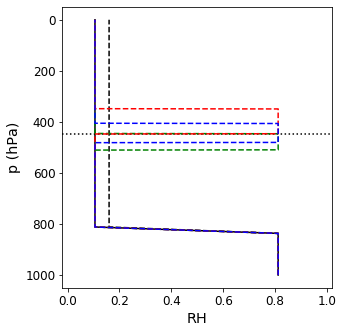

In [49]:
fig,ax = plt.subplots(figsize=(5,5))

ax.plot(rh_ref,pres,'k')
ax.plot(rh_mi,pres,'k--')
ax.axhline(y=p_int,c='k',linestyle=':')
ax.plot(rh_mi_rect_below,pres,'g--')
ax.plot(rh_mi_rect_above,pres,'r--')
ax.plot(rh_mi_rect_centered,pres,'b--')

ax.set_xlabel('RH')
ax.set_ylabel('p (hPa)')
ax.set_xlim((-0.02,1.02))
ax.invert_yaxis()

In [56]:
# moist_intrusions['20200213, upper']['fit']
np.where(z >= 1.92)[0][0]

188